In [1]:
#load up the basics
import os, shutil
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

#image file issue
#https://stackoverflow.com/questions/48395076/keras-giving-oserror-image-file-is-truncated-26-bytes-not-processed
from PIL import ImageFile, Image
ImageFile.LOAD_TRUNCATED_IMAGES = True
Image.MAX_IMAGE_PIXELS = None


#Set GPU to use
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

#import TF stuff
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers
from tensorflow.keras import Model


#Check TensorFlow Version
print('TF version: {}' .format(tf.__version__))

#Check for GPU utilization
if tf.test.gpu_device_name():
    print(' GPU: {}'.format(tf.test.gpu_device_name()))
else:
    print("No GPU")
    


TF version: 2.3.2
 GPU: /device:GPU:0


In [2]:
# build the generator build data generators for training and validaton

# here are the numbers for each storms, if we want to break those out for par. processing.
#(vs. running entire dir of all storms).
# Barry, 8900
# Delta, 9785
# Dorian, 24749
# Florence, 31434
# Gordon, 2019
# Isaias, 8938
# Laura, 24165
# Michael, 9600
# Sally, 6390
# Zeta, 8644
# pred_data_dir = '/data/NOAA_ERI/Florence'


# Define dirs and files
train_data_dir = '/data/NOAA_ERI/'

split = 0.2

total_train = 108200
total_val = 27045



# Add our data-augmentation parameters to ImageDataGenerator and split data
train_datagen = ImageDataGenerator(rescale =1./255.,
                                   horizontal_flip = True,
                                   vertical_flip = True,
                                   validation_split = split)


#set batch Size
batch_size = 32

#latent_dim
z_dim = 50

#set Image size (RGB so imshape is 3)
pix_dim = 512
imsize = (pix_dim,pix_dim) 
imshape = (pix_dim,pix_dim,3)

# Flow training images in batches 
train_generator = train_datagen.flow_from_directory(train_data_dir,
                                                    batch_size = batch_size,
                                                    class_mode = 'input',
                                                    target_size = imsize,
                                                    subset='training')

# Flow validation images in batches 
validation_generator =  train_datagen.flow_from_directory(train_data_dir, # same directory as training data,
                                                        batch_size = batch_size,
                                                        class_mode = 'input',
                                                        target_size = imsize,
                                                        subset='validation')

# define the metrics
#acc_metric = tf.keras.metrics.BinaryAccuracy(name='acc')

Found 108200 images belonging to 13 classes.
Found 27045 images belonging to 13 classes.


In [5]:
#load model
filepath = './models/Autoencoder'
autoencoder = tf.keras.models.load_model(filepath, compile = True)

In [3]:
#build model
##########

input = layers.Input(imshape)

x = layers.Conv2D(32, (3,3), strides=2, activation = "relu", padding = "same")(input)
#x = layers.MaxPooling2D((2,2),padding = "same")(x)
x = layers.Conv2D(32, (3,3), strides=2, activation = "relu", padding = "same")(x)
#x = layers.MaxPooling2D((2,2),padding = "same")(x)
x = layers.Conv2D(32, (3,3), strides = 2, activation = "relu", padding = "same")(x)
#x = layers.MaxPooling2D((2,2),padding = "same")(x)
x = layers.Conv2D(32, (3,3), strides = 2, activation = "relu", padding = "same")(x)
#x = layers.MaxPooling2D((2,2),padding = "same")(x)

x = layers.Flatten()(x)
x = layers.Dense(z_dim)(x)

x = layers.Dense(32*32*32, activation = "relu")(x)
x = layers.Reshape((32,32,32))(x)
x = layers.Conv2DTranspose(32,(3,3), strides = 2, activation = "relu", padding = "same")(x)
x = layers.Conv2DTranspose(32,(3,3), strides = 2, activation = "relu", padding = "same")(x)
x = layers.Conv2DTranspose(32,(3,3), strides = 2, activation = "relu", padding = "same")(x)
x = layers.Conv2DTranspose(32,(3,3), strides = 2, activation = "relu", padding = "same")(x)
x = layers.Conv2DTranspose(3,3, activation = "sigmoid", padding = "same")(x)



autoencoder = Model(input,x)
autoencoder.compile(optimizer = tf.keras.optimizers.Adam(), loss = "binary_crossentropy")
autoencoder.summary()


Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 512, 512, 3)]     0         
_________________________________________________________________
conv2d (Conv2D)              (None, 256, 256, 32)      896       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 128, 128, 32)      9248      
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 64, 64, 32)        9248      
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 32, 32, 32)        9248      
_________________________________________________________________
flatten (Flatten)            (None, 32768)             0         
_________________________________________________________________
dense (Dense)                (None, 50)               

In [3]:
# define a callback

the_callbacks = [tf.keras.callbacks.ModelCheckpoint(filepath='./models/AE_checkpoint_{epoch:02d}-{val_loss:.2f}.h5')]
    
    
#     tf.keras.callbacks.EarlyStopping(monitor = 'val_loss', 
#                                              patience = 10, 
#                                              restore_best_weights = True)



In [6]:
workfolk = 24

history = autoencoder.fit(train_generator,
                    steps_per_epoch = total_train // batch_size,
                    validation_data = validation_generator,
                    epochs= 10,
                    validation_steps =  total_val // batch_size,
                    workers = workfolk,
                    max_queue_size = 6 * workfolk,
                    callbacks = the_callbacks)


Epoch 1/10
3381/3381 [==============================] - 4918s 1s/step - loss: 0.5798 - val_loss: 0.5814
Epoch 2/10
3381/3381 [==============================] - 5035s 1s/step - loss: 0.5798 - val_loss: 0.5813
Epoch 3/10
3381/3381 [==============================] - 5038s 1s/step - loss: 0.5798 - val_loss: 0.5814
Epoch 4/10
3381/3381 [==============================] - 5067s 1s/step - loss: 0.5798 - val_loss: 0.5814
Epoch 5/10
3381/3381 [==============================] - 5110s 2s/step - loss: 0.5798 - val_loss: 0.5813
Epoch 6/10
3381/3381 [==============================] - 5132s 2s/step - loss: 0.5797 - val_loss: 0.5813
Epoch 7/10
 759/3381 [=====>........................] - ETA: 50:28 - loss: 0.5793

KeyboardInterrupt: 

In [7]:
#test model

def ShowAEResult(im):
    img = tf.keras.preprocessing.image.load_img(im,target_size = imsize)
    img = tf.keras.preprocessing.image.img_to_array(img)
    img = img/255
    img = np.expand_dims(img,axis=0)

    predicted = autoencoder.predict(img)


    fig = plt.figure(figsize=(10,10))
    plt.subplot(121)
    plt.imshow(tf.keras.preprocessing.image.load_img(im, target_size = imsize))
    plt.subplot(122)
    plt.imshow(np.squeeze(predicted))

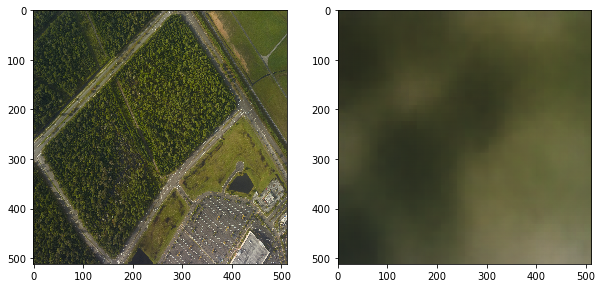

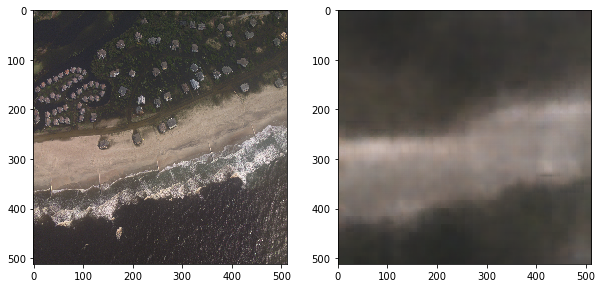

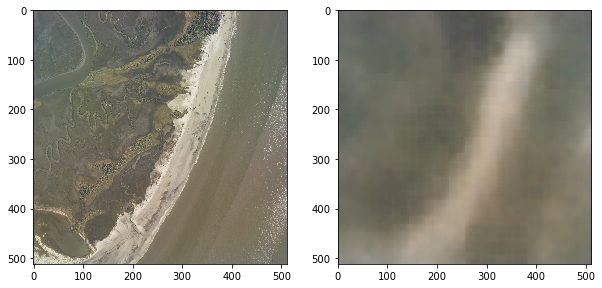

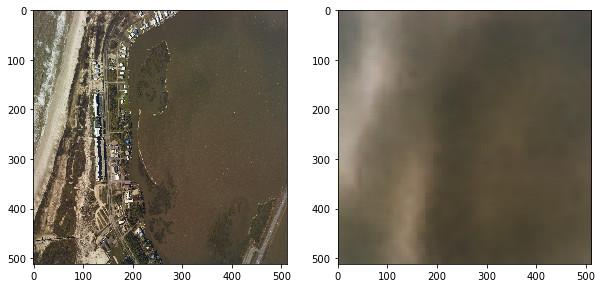

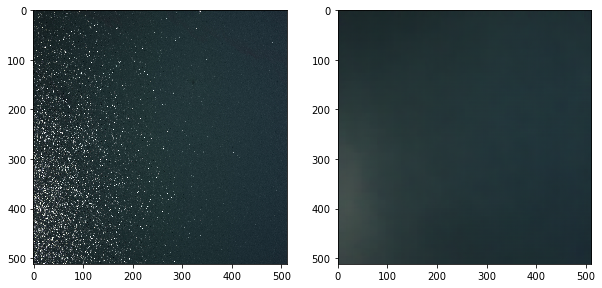

In [8]:
# examples from Florence, Dorian, Zeta, Day 2
ShowAEResult("/data/NOAA_ERI/Florence/20180917a_jpgs/jpgs/C26048812.jpg")
ShowAEResult("/data/NOAA_ERI/Florence/20180917a_jpgs/jpgs/P26055088.jpg")
ShowAEResult("/data/NOAA_ERI/Dorian/20190906a_jpgs/jpgs/C24952838.jpg")
ShowAEResult("/data/NOAA_ERI/Zeta/20201029a_jpgs/jpgs/C30360377.jpg")
ShowAEResult("/data/NOAA_ERI/Henri/20210824a_jpgs/jpgs/018922-0824211724470-RGB2.jpg")

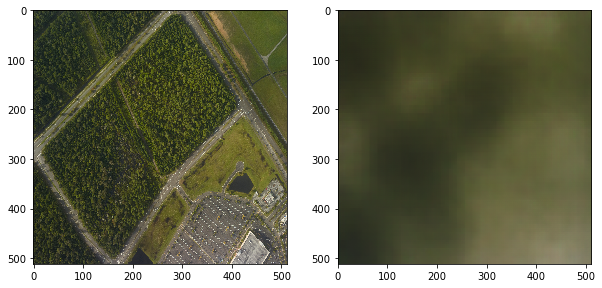

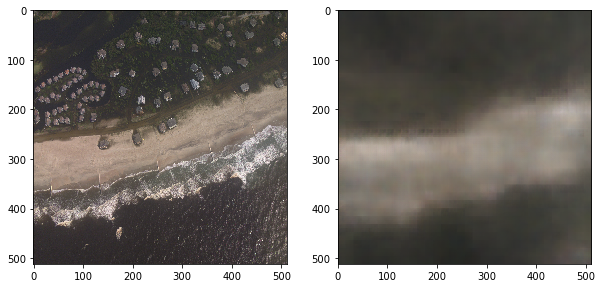

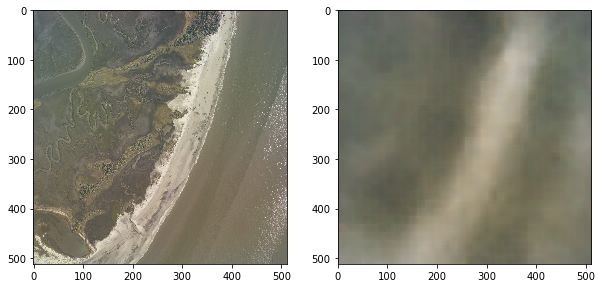

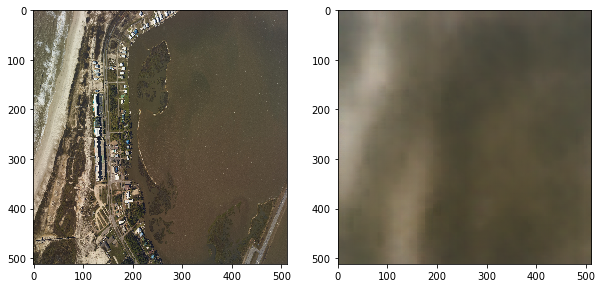

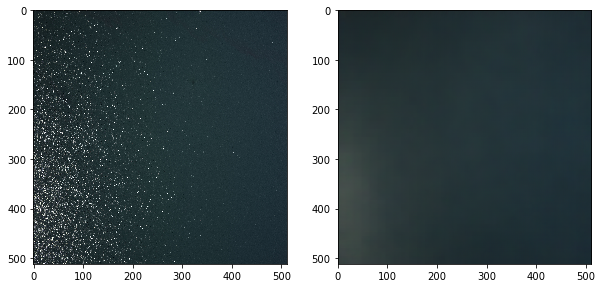

In [20]:
# examples from Florence, Dorian, Zeta, Day 1
ShowAEResult("/data/NOAA_ERI/Florence/20180917a_jpgs/jpgs/C26048812.jpg")
ShowAEResult("/data/NOAA_ERI/Florence/20180917a_jpgs/jpgs/P26055088.jpg")
ShowAEResult("/data/NOAA_ERI/Dorian/20190906a_jpgs/jpgs/C24952838.jpg")
ShowAEResult("/data/NOAA_ERI/Zeta/20201029a_jpgs/jpgs/C30360377.jpg")
ShowAEResult("/data/NOAA_ERI/Henri/20210824a_jpgs/jpgs/018922-0824211724470-RGB2.jpg")

In [9]:
#save the model
filepath = './models/AutoencoderDay2'
autoencoder.save(filepath)

Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
INFO:tensorflow:Assets written to: ./models/AutoencoderDay2/assets


In [ ]:
# #look at the metrics from training
# %matplotlib inline

# acc = history.history['acc']
# val_acc = history.history['val_acc']
# loss = history.history['loss']
# val_loss = history.history['val_loss']

# epochs = range(len(acc))

# plt.plot(epochs, acc, 'r', label='Training accuracy')
# plt.plot(epochs, val_acc, 'b', label='Validation accuracy')

# plt.title('Training and validation accuracy')
# plt.legend(loc=0)
# plt.figure()
# plt.show()

# plt.plot(epochs, loss, 'r--', label='Training loss')
# plt.plot(epochs, val_loss, 'b--', label='Validation loss')
# plt.title('Training and validation loss') 
# plt.legend(loc=0)
# plt.figure()
# plt.show()